In [1]:
## 导入库
import sys, os

sys.path.insert(1, os.path.split(os.path.split(sys.path[0])[0])[0])
import pickle as pkl
import numpy as np
from sklearn import preprocessing
from sklearn.utils import shuffle
from src.neural_net import NeuralNetwork
import matplotlib.pyplot as plt
from tools import save_model, plot_curves,visualize_conv_rgb_layer1, visualize_conv_rgb_layer2, visualize_conv_rgb_layer3
import copy

In [2]:
## 数据准备
def unpickle(file):
    with open(file, 'rb') as fo:
        return pkl.load(fo, encoding='latin1')


# 读取标签
le = preprocessing.LabelEncoder()
le.classes_ = unpickle(sys.path[0] + '/batches.meta')['label_names']

# 读取训练数据
train_images, train_labels = None, []
for i in range(1, 6):
    data = unpickle(sys.path[0] + '/data_batch_' + str(i))
    imgs = data['data'].reshape(-1, 3, 32, 32).astype(np.float64)
    lbls = data['labels']
    train_images = imgs if train_images is None else np.vstack((train_images, imgs))
    train_labels += lbls

# 归一化
mean_image = np.mean(train_images, axis=0)
std = np.std(train_images, axis=0)
train_images = ((train_images - mean_image) / std).astype(np.float32)

# 读取测试数据
data = unpickle(sys.path[0] + '/test_batch')
test_images = data['data'].reshape(-1, 3, 32, 32).astype(np.float64)
test_images = ((test_images - mean_image) / std).astype(np.float32)
test_labels = data['labels']



## 超参数调优

1. 由于我的电脑配置较烂且CNN网络运行时间很久（一个epoch大约需要40Min），所以调优时只划分出数据集的1/10进行测试，只关注accuracy和loss的变化趋势，之前在终端先跑了几个epoch，大概5个可以较好的收敛近最终值（但是准确率不高），因为计算资源有限仅测试3个epoch。

2. 似乎没有严格的理论保证趋势一定不变，但这里认为在实践中，如果验证集是随机抽样的，趋势通常能较好地反映整体情况。

3. 除零错误指示训练过程中存在数值不稳定性，后续避开这些导致溢出/舍入误差的参数。

In [ ]:
## 超参数调优
# 使用训练集的1/10
subset_len = len(train_images) // 10
train_images, train_labels = shuffle(train_images, train_labels)
train_images = train_images[:subset_len]
train_labels = train_labels[:subset_len]

# 参数组合
param_space = {
    'batch_size': [1, 4, 8, 32, 64, 128],
    'lr': [1, 0.1,0.01,0.001,0.0001],
    'learning_rate_decay': [1.0,0.98,0.96,0.9],
    'l2_reg': [1e-3,1e-4,1e-5]
}

# 当前最佳配置
best_config = {
    'batch_size': 1,
    'lr': 1e-4,
    'learning_rate_decay': 0.98,
    'l2_reg': 1e-5
}
best_acc = 0


# 搜索
def evaluate_config(config):
    cnn = NeuralNetwork(train_images.shape[1:], [
        {'type': 'conv', 'k': 16, 'u_type': 'nag', 'f': 5, 's': 1, 'p': 2},
        {'type': 'pool', 'method': 'average'},
        {'type': 'conv', 'k': 20, 'u_type': 'nag', 'f': 5, 's': 1, 'p': 2},
        {'type': 'pool', 'method': 'average'},
        {'type': 'conv', 'k': 20, 'u_type': 'nag', 'f': 5, 's': 1, 'p': 2},
        {'type': 'pool', 'method': 'average'},
        {'type': 'output', 'k': len(le.classes_), 'u_type': 'adam'}
    ], config['lr'], l2_reg=config['l2_reg'])

    cnn.lr_decay = config['learning_rate_decay']
    cnn.epoch_count = 0
    cnn.t = 0

    for epoch in range(3):
        print(f"\n=== Epoch {epoch + 1} start... ===")
        images, labels = shuffle(train_images, train_labels)
        for i in range(0, len(images), config['batch_size']):
            batch_x = images[i:i+config['batch_size']]
            batch_y = labels[i:i+config['batch_size']]
            cnn.t += 1
            cnn.epoch(batch_x, batch_y)

        cnn.epoch_count += 1
        cnn.lr *= cnn.lr_decay

        train_loss, train_acc = cnn.predict(train_images, train_labels)
        test_loss, test_acc = cnn.predict(test_images[:800], test_labels[:800])

        print(f"=== Epoch {epoch + 1} finish. ===")
        print(f"Train acc: {train_acc:.4f}, Train loss: {train_loss:.4f}")
        print(f"Test acc: {test_acc:.4f}, Test loss: {test_loss:.4f}")

    # 返回最后一次评估的 test acc
    return test_acc, config


# 对每个参数进行调优
for key in ['batch_size', 'lr', 'learning_rate_decay', 'l2_reg']:
    values = param_space[key]
    print(f"Tuning {key}...")
    for v in values:
        config = best_config.copy()
        config[key] = v
        acc, tested_cfg = evaluate_config(config)
        print(f"{key}={v}, acc={acc}")
        if acc > best_acc:
            best_acc = acc
            best_config = tested_cfg
            print(">> New best config:", best_config, "acc=", acc)

print("=== Best Config Found ===")
print(best_config)
print("Best accuracy:", best_acc)

Tuning batch_size...

=== Epoch 1 start... ===
=== Epoch 1 finish. ===
Train acc: 35.0217, Train loss: 1.8562
Test acc: 33.1250, Test loss: 1.8727

=== Epoch 2 start... ===
=== Epoch 2 finish. ===
Train acc: 41.2826, Train loss: 1.6814
Test acc: 38.8750, Test loss: 1.7214

=== Epoch 3 start... ===
=== Epoch 3 finish. ===
Train acc: 43.4348, Train loss: 1.5788
Test acc: 40.7500, Test loss: 1.6406
batch_size=1, acc=40.75
>> New best config: {'batch_size': 1, 'lr': 0.0001, 'learning_rate_decay': 0.98, 'l2_reg': 1e-05} acc= 40.75

=== Epoch 1 start... ===
=== Epoch 1 finish. ===
Train acc: 18.9783, Train loss: 2.2306
Test acc: 18.8750, Test loss: 2.2407

=== Epoch 2 start... ===
=== Epoch 2 finish. ===
Train acc: 20.2609, Train loss: 2.1604
Test acc: 18.6250, Test loss: 2.1792

=== Epoch 3 start... ===
=== Epoch 3 finish. ===
Train acc: 21.3913, Train loss: 2.2102
Test acc: 22.7500, Test loss: 2.2281
batch_size=4, acc=22.75

=== Epoch 1 start... ===
=== Epoch 1 finish. ===
Train acc: 15.15

c:\Users\lenovo\PycharmProjects\Computer Vision\Project1\src\utils.py:21: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(probs[range(N), y])) / N


=== Epoch 1 finish. ===
Train acc: 10.8043, Train loss: 2.5084
Test acc: 9.7500, Test loss: 2.5180

=== Epoch 2 start... ===
=== Epoch 2 finish. ===
Train acc: 9.2826, Train loss: 2.4245
Test acc: 9.3750, Test loss: 2.4193

=== Epoch 3 start... ===
=== Epoch 3 finish. ===
Train acc: 10.8696, Train loss: 2.4112
Test acc: 11.8750, Test loss: 2.4103
lr=1, acc=11.875

=== Epoch 1 start... ===
=== Epoch 1 finish. ===
Train acc: 10.3913, Train loss: 2.3157
Test acc: 11.5000, Test loss: 2.3183

=== Epoch 2 start... ===
=== Epoch 2 finish. ===
Train acc: 9.9130, Train loss: 2.3135
Test acc: 8.2500, Test loss: 2.3177

=== Epoch 3 start... ===
=== Epoch 3 finish. ===
Train acc: 10.8043, Train loss: 2.3108
Test acc: 9.7500, Test loss: 2.3107
lr=0.1, acc=9.75

=== Epoch 1 start... ===
=== Epoch 1 finish. ===
Train acc: 10.8043, Train loss: 2.3023
Test acc: 9.7500, Test loss: 2.3009

=== Epoch 2 start... ===
=== Epoch 2 finish. ===
Train acc: 10.8043, Train loss: 2.3027
Test acc: 9.7500, Test loss:

Epoch 1/20 - lr=0.000100
Train Loss: 1.3927 | Train Acc: 51.3250
Val   Loss: 1.3664 | Val   Acc: 51.4250
--> New best model saved (val acc = 51.4250)
Epoch 2/20 - lr=0.000096
Train Loss: 1.1950 | Train Acc: 58.0500
Val   Loss: 1.2089 | Val   Acc: 56.7500
--> New best model saved (val acc = 56.7500)
Epoch 3/20 - lr=0.000092
Train Loss: 1.1044 | Train Acc: 61.3750
Val   Loss: 1.1496 | Val   Acc: 58.9250
--> New best model saved (val acc = 58.9250)
Epoch 4/20 - lr=0.000088
Train Loss: 1.0403 | Train Acc: 63.8000
Val   Loss: 1.0613 | Val   Acc: 62.7500
--> New best model saved (val acc = 62.7500)
Epoch 5/20 - lr=0.000085
Train Loss: 0.9797 | Train Acc: 65.3500
Val   Loss: 0.9937 | Val   Acc: 65.6250
--> New best model saved (val acc = 65.6250)
Epoch 6/20 - lr=0.000082
Train Loss: 0.9649 | Train Acc: 66.2500
Val   Loss: 1.0160 | Val   Acc: 63.9250
Epoch 7/20 - lr=0.000078
Train Loss: 0.8868 | Train Acc: 68.7500
Val   Loss: 0.9946 | Val   Acc: 65.3500
Epoch 8/20 - lr=0.000075
Train Loss: 0.8

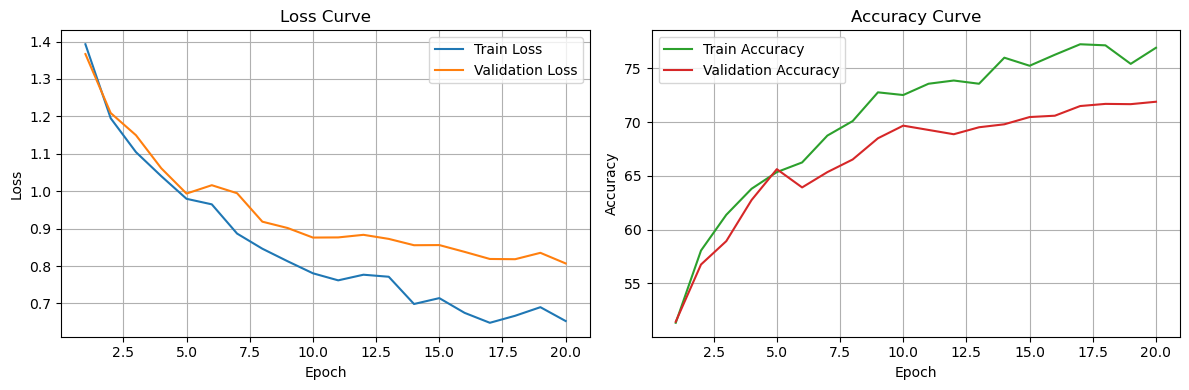

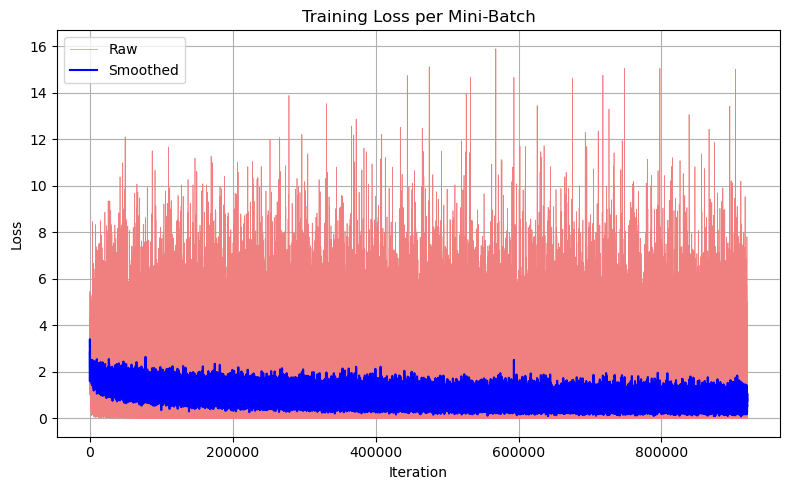

First Layer Conv Kernels:


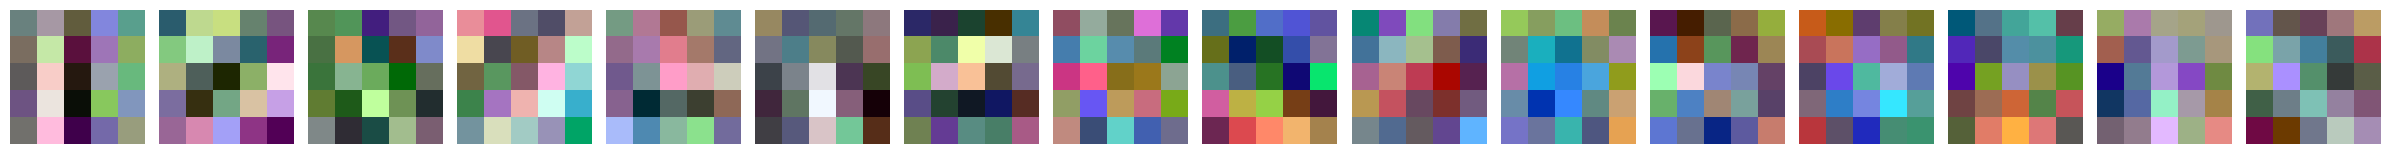

Second Layer Conv Kernels:


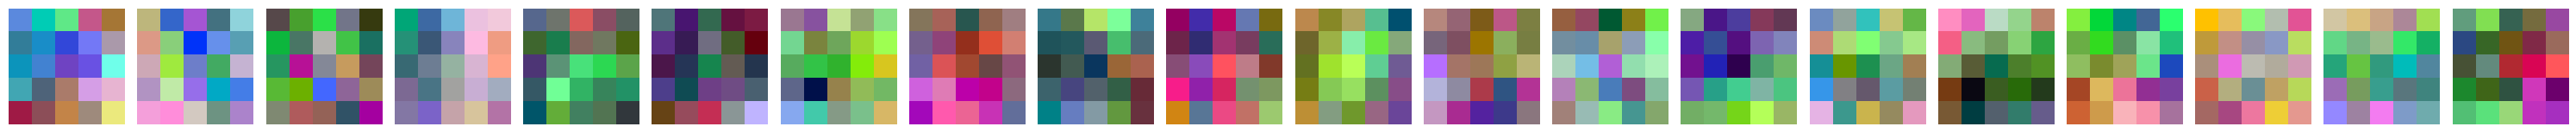

Third Layer Conv Kernels:


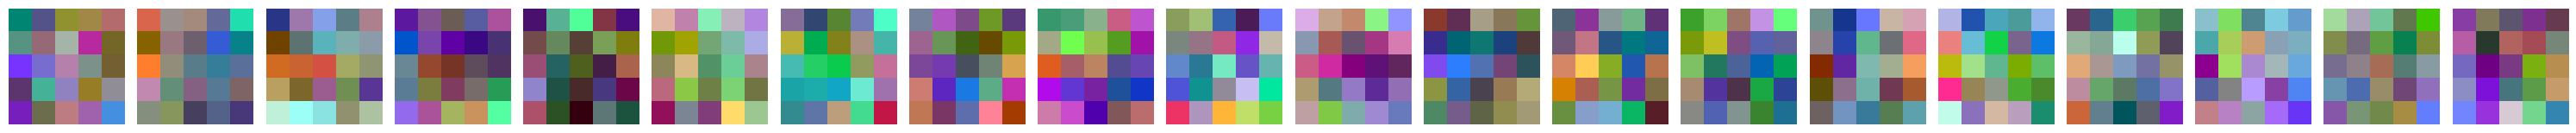

In [37]:
import sys, os
sys.path.insert(1, os.path.split(os.path.split(sys.path[0])[0])[0])

import pickle as pkl
import numpy as np
from sklearn import preprocessing
from sklearn.utils import shuffle
from src.neural_net import NeuralNetwork
from tools import save_model, plot_curves, visualize_conv_rgb_layer1, visualize_conv_rgb_layer2, visualize_conv_rgb_layer3
import copy

# ---------- 数据处理 ----------
def unpickle(file):
    with open(file, 'rb') as fo:
        return pkl.load(fo, encoding='latin1')

le = preprocessing.LabelEncoder()
le.classes_ = unpickle(sys.path[0] + '/batches.meta')['label_names']

# 加载训练数据
train_images, train_labels = None, []
for i in range(1, 6):
    data = unpickle(sys.path[0] + f'/data_batch_{i}')
    train_images = data['data'] if train_images is None else np.vstack((train_images, data['data']))
    train_labels += data['labels']

train_images = train_images.reshape(-1, 3, 32, 32).astype(np.float64)
mean_image = np.mean(train_images, axis=0)
std = np.std(train_images, axis=0)
train_images = ((train_images - mean_image) / std).astype(np.float32)

# 验证集划分
train_images, train_labels = shuffle(train_images, train_labels, random_state=42)
val_images = train_images[:4000]
val_labels = train_labels[:4000]
train_images = train_images[4000:]
train_labels = train_labels[4000:]

# 测试集处理
test_data = unpickle(sys.path[0] + '/test_batch')
test_images = test_data['data'].reshape(-1, 3, 32, 32).astype(np.float64)
test_images = ((test_images - mean_image) / std).astype(np.float32)
test_labels = test_data['labels']

# ---------- 模型超参数 ----------
lr = 1e-4
l2_reg = 1e-5
decay = 0.96
batch_size = 1
num_epochs = 20

cnn = NeuralNetwork(
    train_images.shape[1:],
    [
        {'type': 'conv', 'k': 16, 'u_type': 'nag', 'f': 5, 's': 1, 'p': 2},
        {'type': 'pool', 'method': 'average'},
        {'type': 'conv', 'k': 20, 'u_type': 'nag', 'f': 5, 's': 1, 'p': 2},
        {'type': 'pool', 'method': 'average'},
        {'type': 'conv', 'k': 20, 'u_type': 'nag', 'f': 5, 's': 1, 'p': 2},
        {'type': 'pool', 'method': 'average'},
        {'type': 'output', 'k': len(le.classes_), 'u_type': 'adam'}
    ],
    lr, l2_reg=l2_reg
)

# ---------- 训练主循环 ----------
best_model = None
best_val_acc = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []
batch_losses = []

for epoch in range(num_epochs):
    # Shuffle 每个 epoch
    train_images, train_labels = shuffle(train_images, train_labels)

    # mini-batch 训练
    for i in range(0, len(train_images), batch_size):
        x_batch = train_images[i:i+batch_size]
        y_batch = train_labels[i:i+batch_size]
        cnn.t += 1
        loss, acc = cnn.epoch(x_batch, y_batch)

        batch_losses.append(loss)

    # epoch 完成：评估
    train_loss, train_acc = cnn.predict(train_images[:4000], train_labels[:4000])
    val_loss, val_acc = cnn.predict(val_images, val_labels)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - lr={cnn.lr:.6f}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    # 保存最优模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = copy.deepcopy(cnn)
        print(f"--> New best model saved (val acc = {val_acc:.4f})")

    # 衰减学习率
    cnn.lr *= decay

# ---------- 测试集评估 ----------
test_loss, test_acc = best_model.predict(test_images, test_labels)
print(f"\nFinal Test Accuracy: {test_acc:.4f} | Loss: {test_loss:.4f}")

# ---------- 保存模型 ----------
save_model(best_model, "best_model.pkl")
print(f"\nBest model saved as 'best_model.pkl' with val acc = {best_val_acc:.4f}")

# ---------- 可视化：epoch 级 ----------
plot_curves(train_losses, val_losses, train_accs, val_accs)

# ---------- 可视化：每个 mini-batch 的 loss ----------
def smooth_curve(values, window=20):
    smoothed = np.convolve(values, np.ones(window)/window, mode='valid')
    return np.concatenate([values[:window-1], smoothed])

def plot_batch_loss_curve(batch_losses):
    iterations = np.arange(1, len(batch_losses) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(iterations, batch_losses, color='lightcoral', linewidth=0.5, label='Raw')
    plt.plot(iterations, smooth_curve(batch_losses), color='blue', linewidth=1.5, label='Smoothed')
    plt.title("Training Loss per Mini-Batch")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_batch_loss_curve(batch_losses)

# ---------- 可视化卷积核 ----------
print("First Layer Conv Kernels:")
visualize_conv_rgb_layer1(best_model.layers[0], 16)

print("Second Layer Conv Kernels:")
visualize_conv_rgb_layer2(best_model.layers[2], 20)

print("Third Layer Conv Kernels:")
visualize_conv_rgb_layer3(best_model.layers[4], 20)


rm:之前已经试训练过一次，数据如上图，训练到第20轮的时候发现loss开始回升了而且accuracy从之前就提升幅度很小，所以提前停止训练。第二次把轮数设置为20轮

| Epoch | Learning Rate | Train Loss | Train Acc | Val Loss | Val Acc | Notes |
|-------|---------------|------------|-----------|----------|---------|-------|
| 1/30  | 0.000100      | 1.3000     | 54.6000   | 1.3536   | 52.5750 | New best model saved (val acc = 52.5750) |
| 2/30  | 0.000096      | 1.1725     | 58.5500   | 1.1968   | 57.8000 | New best model saved (val acc = 57.8000) |
| 3/30  | 0.000092      | 1.0704     | 63.3250   | 1.1337   | 60.5250 | New best model saved (val acc = 60.5250) |
| 4/30  | 0.000088      | 0.9995     | 65.0250   | 1.0740   | 62.8750 | New best model saved (val acc = 62.8750) |
| 5/30  | 0.000085      | 0.9661     | 66.0250   | 1.0292   | 63.6750 | New best model saved (val acc = 63.6750) |
| 6/30  | 0.000082      | 0.9168     | 68.3500   | 0.9788   | 65.9250 | New best model saved (val acc = 65.9250) |
| 7/30  | 0.000078      | 0.8876     | 68.6000   | 0.9563   | 66.2000 | New best model saved (val acc = 66.2000) |
| 8/30  | 0.000075      | 0.8177     | 71.2000   | 0.9098   | 68.1500 | New best model saved (val acc = 68.1500) |
| 9/30  | 0.000072      | 0.8600     | 70.7000   | 0.9158   | 67.2750 | - |
| 10/30 | 0.000069      | 0.7584     | 74.2500   | 0.8818   | 69.1000 | New best model saved (val acc = 69.1000) |
| 11/30 | 0.000066      | 0.7242     | 75.5750   | 0.8568   | 70.1000 | New best model saved (val acc = 70.1000) |
| 12/30 | 0.000064      | 0.7343     | 74.4000   | 0.8267   | 71.7500 | New best model saved (val acc = 71.7500) |
| 13/30 | 0.000061      | 0.6809     | 76.5500   | 0.8413   | 70.6750 | - |
| 14/30 | 0.000059      | 0.7231     | 75.4000   | 0.8590   | 70.2250 | - |
| 15/30 | 0.000056      | 0.6981     | 75.7500   | 0.8366   | 71.0000 | - |
| 16/30 | 0.000054      | 0.6525     | 77.0000   | 0.8309   | 71.6250 | - |
| 17/30 | 0.000052      | 0.6549     | 77.4250   | 0.8173   | 71.4750 | - |
| 18/30 | 0.000050      | 0.6666     | 77.4000   | 0.8299   | 71.6500 | - |
| 19/30 | 0.000048      | 0.6298     | 78.6750   | 0.8182   | 72.0250 | New best model saved (val acc = 72.0250) |
| 20/30 | 0.000046      | 0.6096     | 78.0250   | 0.8175   | 71.9000 | - |
| 21/30 | 0.000044      | 0.6357     | 77.8000   | 0.8244   | 71.5750 | - |


In [ ]:
import sys, os
sys.path.insert(1, os.path.split(os.path.split(sys.path[0])[0])[0])

import pickle as pkl
import numpy as np
from sklearn import preprocessing
from sklearn.utils import shuffle
from src.neural_net import NeuralNetwork
from tools import save_model, plot_curves, visualize_conv_rgb_layer1, visualize_conv_rgb_layer2, visualize_conv_rgb_layer3
import copy

# ---------- 数据处理 ----------
def unpickle(file):
    with open(file, 'rb') as fo:
        return pkl.load(fo, encoding='latin1')

le = preprocessing.LabelEncoder()
le.classes_ = unpickle(sys.path[0] + '/batches.meta')['label_names']

# 加载训练数据
train_images, train_labels = None, []
for i in range(1, 6):
    data = unpickle(sys.path[0] + f'/data_batch_{i}')
    train_images = data['data'] if train_images is None else np.vstack((train_images, data['data']))
    train_labels += data['labels']

train_images = train_images.reshape(-1, 3, 32, 32).astype(np.float64)
mean_image = np.mean(train_images, axis=0)
std = np.std(train_images, axis=0)
train_images = ((train_images - mean_image) / std).astype(np.float32)

# 验证集划分
train_images, train_labels = shuffle(train_images, train_labels, random_state=42)
val_images = train_images[:4000]
val_labels = train_labels[:4000]
train_images = train_images[4000:]
train_labels = train_labels[4000:]

# 测试集处理
test_data = unpickle(sys.path[0] + '/test_batch')
test_images = test_data['data'].reshape(-1, 3, 32, 32).astype(np.float64)
test_images = ((test_images - mean_image) / std).astype(np.float32)
test_labels = test_data['labels']

# ---------- 模型超参数 ----------
lr = 1e-4
l2_reg = 1e-5
decay = 0.96
batch_size = 1
num_epochs = 30

cnn = NeuralNetwork(
    train_images.shape[1:],
    [
        {'type': 'conv', 'k': 16, 'u_type': 'nag', 'f': 5, 's': 1, 'p': 2},
        {'type': 'pool', 'method': 'average'},
        {'type': 'conv', 'k': 20, 'u_type': 'nag', 'f': 5, 's': 1, 'p': 2},
        {'type': 'pool', 'method': 'average'},
        {'type': 'conv', 'k': 20, 'u_type': 'nag', 'f': 5, 's': 1, 'p': 2},
        {'type': 'pool', 'method': 'average'},
        {'type': 'output', 'k': len(le.classes_), 'u_type': 'adam'}
    ],
    lr, l2_reg=l2_reg
)

# ---------- 训练主循环 ----------
best_model = None
best_val_acc = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    # Shuffle 每个 epoch
    train_images, train_labels = shuffle(train_images, train_labels)

    # mini-batch 训练
    for i in range(0, len(train_images), batch_size):
        x_batch = train_images[i:i+batch_size]
        y_batch = train_labels[i:i+batch_size]
        cnn.t += 1
        loss, acc = cnn.epoch(x_batch, y_batch)

    # epoch 完成：评估
    train_loss, train_acc = cnn.predict(train_images[:4000], train_labels[:4000])
    val_loss, val_acc = cnn.predict(val_images, val_labels)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - lr={cnn.lr:.6f}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    # 保存最优模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = copy.deepcopy(cnn)
        print(f"--> New best model saved (val acc = {val_acc:.4f})")

    # 衰减学习率
    cnn.lr *= decay

# ---------- 测试集评估 ----------
test_loss, test_acc = best_model.predict(test_images, test_labels)
print(f"\nFinal Test Accuracy: {test_acc:.4f} | Loss: {test_loss:.4f}")

# ---------- 保存模型 ----------
save_model(best_model, "best_model.pkl")
print(f"\nBest model saved as 'best_model.pkl' with val acc = {best_val_acc:.4f}")

# ---------- 可视化 ----------
plot_curves(train_losses, val_losses, train_accs, val_accs)

print("First Layer Conv Kernels:")
visualize_conv_rgb_layer1(best_model.layers[0], 16)

print("Second Layer Conv Kernels:")
visualize_conv_rgb_layer2(best_model.layers[2], 20)

print("Third Layer Conv Kernels:")
visualize_conv_rgb_layer3(best_model.layers[4], 20)



Epoch 1/30 - lr=0.000100
Train Loss: 1.3000 | Train Acc: 54.6000
Val   Loss: 1.3536 | Val   Acc: 52.5750
--> New best model saved (val acc = 52.5750)
Epoch 2/30 - lr=0.000096
Train Loss: 1.1725 | Train Acc: 58.5500
Val   Loss: 1.1968 | Val   Acc: 57.8000
--> New best model saved (val acc = 57.8000)
Epoch 3/30 - lr=0.000092
Train Loss: 1.0704 | Train Acc: 63.3250
Val   Loss: 1.1337 | Val   Acc: 60.5250
--> New best model saved (val acc = 60.5250)
Epoch 4/30 - lr=0.000088
Train Loss: 0.9995 | Train Acc: 65.0250
Val   Loss: 1.0740 | Val   Acc: 62.8750
--> New best model saved (val acc = 62.8750)
Epoch 5/30 - lr=0.000085
Train Loss: 0.9661 | Train Acc: 66.0250
Val   Loss: 1.0292 | Val   Acc: 63.6750
--> New best model saved (val acc = 63.6750)
Epoch 6/30 - lr=0.000082
Train Loss: 0.9168 | Train Acc: 68.3500
Val   Loss: 0.9788 | Val   Acc: 65.9250
--> New best model saved (val acc = 65.9250)
Epoch 7/30 - lr=0.000078
Train Loss: 0.8876 | Train Acc: 68.6000
Val   Loss: 0.9563 | Val   Acc: 66.

KeyboardInterrupt: 

## 模型训练过程分析


### 左图：Loss Curve

1. Train Loss（蓝线）持续下降，说明模型在训练集上收敛良好；

2. Validation Loss（橙线）也总体下降，但从第 10 个 epoch 左右开始，下降幅度略趋于平缓，（不过跟FCNN比已经好很多了感觉）；可能是由于模型在训练集上拟合能力增强，但是在验证集上出现轻微过拟合趋势，但认为整体仍在可接受范围内。

### 右图：Accuracy Curve
1. Train Accuracy（绿线）持续上升，达到约 78%，验证训练有效；

2. Validation Accuracy（红线）也稳步提升，最终稳定在 72% 左右；

训练与验证精度之间存在一定差距，暗示模型可能略有过拟合，但尚未失控。

### 测试

导入训练好的模型进行测试，在test集上的accuracy为71.40，loss为0.8417

## 卷积核可视化分析

### 第一层卷积核（Conv Layer 1）

该层接收到的是原始图像像素输入，主要提取低级特征，如边缘、颜色、方向、纹理等；

部分卷积核具有强烈的方向性（如水平/垂直边缘检测）。

### 第二层卷积核（Conv Layer 2）

第二层卷积核以第一层输出的特征图为输入，进一步组合低级特征；

图像看起来比第一层更复杂，出现更多模糊的颜色混合和局部模式；

开始形成对局部纹理、简单组合结构的响应。

### 第三层卷积核（Conv Layer 3）

第三层是更深层的卷积操作，卷积核的可视化效果更加抽象；

难以直观识别具体模式，说明该层捕捉的是更高阶的抽象特征，有助于模型完成更复杂的分类决策。